In [3]:
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, MultiPoint , Polygon, MultiPolygon

import requests
import time
from PIL import Image
from io import BytesIO

from sklearn.cluster import DBSCAN

In [2]:
# Fetch the street network from OSM
place_name = "Stuttgart, Germany"
G = ox.graph_from_place(place_name, network_type='bike', simplify=True)

# Look at the network
#fig, ax = ox.plot_graph(ox.project_graph(G))

# Convert the graph into two GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Extract midpoints for every edge of the street network
edges['midpoint'] = ''
for i in range(0,len(edges)):
    midpoint = edges['geometry'].iloc[i].interpolate(0.5, normalized = True)
    edges['midpoint'].iloc[i] = midpoint

C:\Users\Zhenzhen\AppData\Local\Temp\ipykernel_10076\3638368318.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges['midpoint'].iloc[i] = midpoint


In [4]:
#### OPTION 2: Too many roads > Cluster roads > Get midpoints of clusters > Get streetview images

# Convert road midpoints to a numpy array for clustering
coords = np.array(edges['midpoint'])

# Extract longitude and latitude from each Point
lon_lat_array = np.array([(point.x, point.y) for point in edges['midpoint']])

# Convert longitude and latitude to radians
coords_in_radians = np.radians(lon_lat_array)

# Perform DBSCAN clustering
epsilon = 0.00001  # Cluster radius in degrees
min_samples = 1  # Minimum samples in a cluster
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='auto', metric='haversine').fit(coords_in_radians)
edges['cluster'] = db.labels_

# Check the number of clusters formed
num_clusters = len(set(edges['cluster'])) - (1 if -1 in edges['cluster'] else 0)
print(f"Number of clusters: {num_clusters}")

Number of clusters: 10235


C:\Users\Zhenzhen\AppData\Local\Temp\ipykernel_10076\2905742439.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', num_clusters)


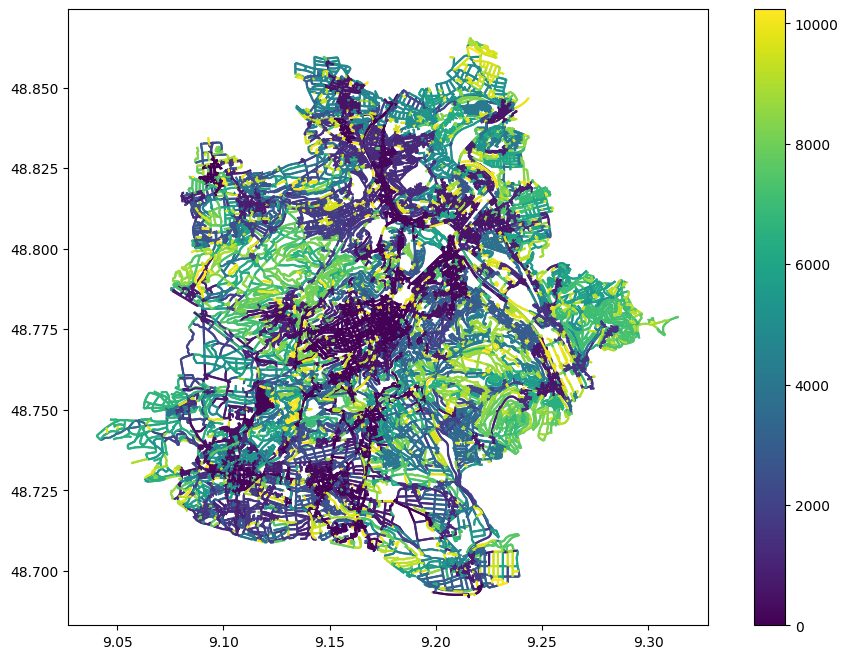

In [5]:
## VISUALIZE CLUSTERS 1
import matplotlib.cm as cm

# Assign a color to each cluster using a colormap
num_clusters = len(set(edges['cluster'])) - (1 if -1 in edges['cluster'] else 0)
colormap = cm.get_cmap('viridis', num_clusters)

# Normalize cluster labels for color mapping
norm = plt.Normalize(vmin=edges['cluster'].min(), vmax=edges['cluster'].max())

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
edges.plot(column='cluster', ax=ax, cmap=colormap, norm=norm)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical')

plt.show()